<xarray.DataArray ()>
array((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), dtype=object)
<xarray.DataArray ()>
array((20140116, 20140216, 20140316, 20140416, 20140516, 20140616, 20140716, 20140816, 20140916, 20141016, 20141116, 20141216),
      dtype=object)
<xarray.Dataset>
Dimensions:    (bound: 2, lat: 360, lon: 720, time: 12)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) object 2014-01-16 00:00:00 ... 2014-12-16 00:00:00
Dimensions without coordinates: bound
Data variables:
    lat_bnds   (lat, bound) float64 -90.0 -89.5 -89.5 -89.0 ... 89.5 89.5 90.0
    lon_bnds   (lon, bound) float64 -180.0 -179.5 -179.5 ... 179.5 179.5 180.0
    time_bnds  (time, bound) object 2014-01-01 00:00:00 ... 2015-01-01 00:00:00
    emis_agr   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    emis_ene   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 .

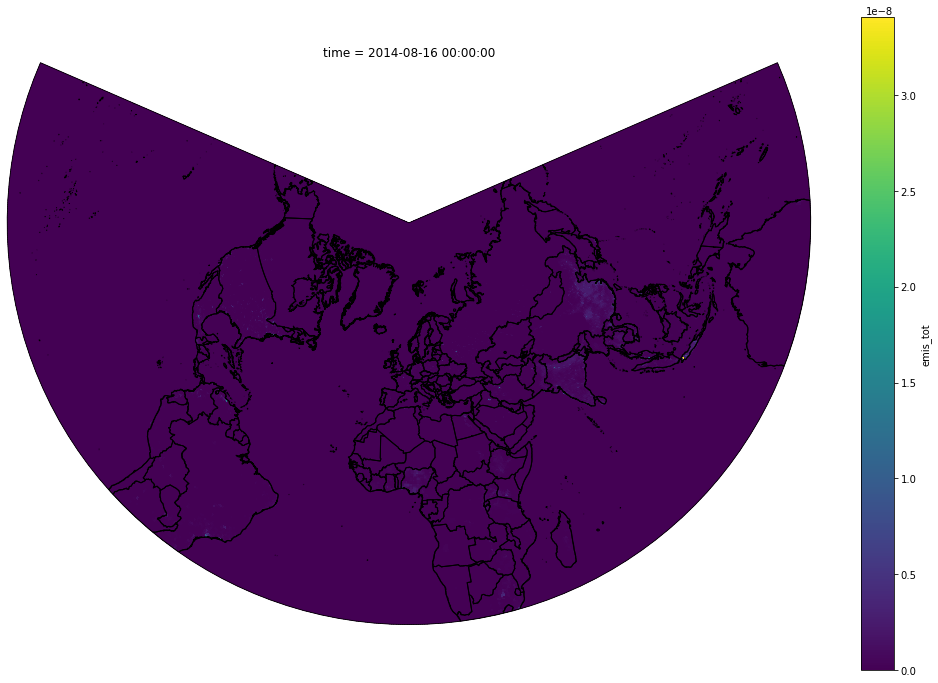

In [40]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import (OCEAN, LAKES, BORDERS, COASTLINE, RIVERS, COLORS,
                             LAND)

#CMIP6 data has anthropogenic and aircraft emissions as separate files. Import both so they can be combined.
ds = xr.open_dataset('F:/historic_emissions/CO-em-anthro_input4MIPs_emissions_CMIP_CEDS-v2016-07-26-sectorDim_gn_200001-201412.nc')
air_ds = xr.open_dataset('F:/historic_emissions/CO-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-08-30_gn_200001-201412.nc')


relev_ds = ds.sel(time=slice("2014-01-01","2014-12-16")) #extract 2014 emissions from anthro database
relev_air_ds =air_ds.sel(time=slice("2014-01-01", "2014-12-16")).mean(dim='level') #average over levels as WRF-Chem doesn't do emissions from different levels as default (CHECK?)

#this section separates the sectors as individual arrays

emis_agr = relev_ds.isel(sector=0).reset_coords("sector")
emis_agr['emis_agr'] = emis_agr['CO_em_anthro']+0 #adding +0 because otherwise I think dropping CO_em_anthro turns everything into NaN
emis_agr = emis_agr.drop_vars('CO_em_anthro')
emis_agr =emis_agr.drop_vars('sector') #no idea why it won't let me drop both simultaneously, but it won't
emis_agr = emis_agr.drop_vars('sector_bnds')
emis_ene = relev_ds.isel(sector=1).reset_coords("sector")
emis_ene['emis_ene'] = emis_ene['CO_em_anthro']+0
emis_ene = emis_ene.drop_vars('CO_em_anthro')
emis_ene = emis_ene.drop_vars('sector')
emis_ene = emis_ene.drop_vars('sector_bnds')
emis_ind = relev_ds.isel(sector=2).reset_coords("sector") 
solvent = relev_ds.isel(sector=5).reset_coords("sector") #combined based on EDGAR-HTAP2 method
emis_tra = relev_ds.isel(sector=3).reset_coords("sector")
emis_tra['emis_tra'] = emis_tra['CO_em_anthro']+0
emis_tra = emis_tra.drop_vars('CO_em_anthro')
emis_tra = emis_tra.drop_vars('sector')
emis_tra = emis_tra.drop_vars('sector_bnds')
emis_res = relev_ds.sel(sector=4).reset_coords("sector")
waste = relev_ds.sel(sector=6).reset_coords("sector") #combined based on EDGAR-HATP2 method
emis_shp = relev_ds.isel(sector=7).reset_coords("sector")
emis_shp['emis_shp'] = emis_shp['CO_em_anthro']+0
emis_shp = emis_shp.drop_vars('CO_em_anthro')
emis_shp = emis_shp.drop_vars('sector')
emis_shp = emis_shp.drop_vars('sector_bnds')

#do aircraft separately from different file

emis_air = relev_air_ds
emis_air['emis_air'] = emis_air['CO_em_AIR_anthro']+0  #aircraft emissions aren't split by sector
#emis_air = emis_air.drop_vars('level')
#emis_air = emis_air.squeeze('level')
emis_air = emis_air.drop_vars('CO_em_AIR_anthro')
#test this section
#print (emis_shp) #just to compare variables

#this next bit combines some sectors in the CMIP emissions 


emis_ind['emis_ind'] =emis_ind['CO_em_anthro'] + solvent['CO_em_anthro']
emis_ind = emis_ind.drop_vars('CO_em_anthro')
emis_ind = emis_ind.drop_vars('sector')
emis_ind = emis_ind.drop_vars('sector_bnds')
emis_res['emis_res'] =emis_res['CO_em_anthro'] + waste['CO_em_anthro']
emis_res = emis_res.drop_vars('CO_em_anthro')
emis_res = emis_res.drop_vars('sector')
emis_res = emis_res.drop_vars('sector_bnds')


#use the same method for total emissions

emis_tot = relev_ds.isel(sector=0).reset_coords("sector",drop=True)
emis_tot['emis_tot'] = emis_agr['emis_agr']+emis_ene['emis_ene']+emis_tra['emis_tra']+emis_shp['emis_shp']+emis_ind['emis_ind']+emis_res['emis_res'] +emis_air['emis_air']
emis_tot = emis_tot.drop_vars('CO_em_anthro')
emis_tot = emis_tot.drop_vars('sector_bnds')

#just reading this in for a test plot. Hash out if you know the code works as it makes it slow
statesetc = shpreader.natural_earth(resolution='10m',# downloads country borders from Natural Earth
                                      category='cultural',
                                      name='admin_0_countries') #
shape_feature_another = ShapelyFeature(Reader(statesetc).geometries(),
                                ccrs.PlateCarree(), edgecolor='black', facecolor = 'none') #setting the facecolor as none is important, otherwise you can't see what is being plotted

#for reasons which are currently unclear, there must be a datesec and date variable

array =0,0,0,0,0,0,0,0,0,0,0,0
datesec = xr.DataArray(array) #this transforms them into a data array, which is needed to add them as variables
print (datesec)


dates =20140116, 20140216, 20140316, 20140416, 20140516, 20140616, 20140716, 20140816, 20140916, 20141016, 20141116, 20141216 #CMIP6 data only goes up to 16th Dec each year
#the above and datesec are int objects in 
date = xr.DataArray(dates)
print (date)

merge1 = emis_agr.merge(emis_ene)
merge2 = merge1.merge(emis_ind)
merge3 = merge2.merge(emis_tra)
merge4 = merge3.merge(emis_res)
merge5 = merge4.merge(emis_shp)
merge6 = merge5.merge(emis_air,compat='override') #seem to need to add this override because of incompatible lat/lon bounds. I don't know if this'll cause any issues
merge7 = merge6.merge(emis_tot)
merge7['datesec'] = datesec #these two don't merge properly, but can be added as variables
merge7['date'] = date



#final_file.assign(datesec)
#final_file = final_file.reset_coords("datesec")

#plot and print to check output

print(merge7)
to_plot = merge7['emis_tot'].isel(time=7) #test plot to see if merging functions



fig = plt.figure (figsize = (18, 12))
ax =plt.axes(projection = ccrs.LambertConformal(central_longitude =5.4)) 
ax.coastlines()


ax.add_feature(shape_feature_another) 
to_plot.plot(transform=ccrs.PlateCarree())
plt.show()

#merge7.to_netcdf() probably rename file to something meaningful first. Uncomment and add path when in ARC
